# Analysis of pre- and post-incubation chromatographic data

In this notebook a detailed analysis is provided of the assigned spectra from the GC-FID and LC-Orbitrap-MS.
Different statistical methods were used to differentiate between synthesis methods.

In [2]:
import copy, os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import gaussian_kde
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
import seaborn as sns

## Use synthesis method as class variable

### Read data

In the long format, each compound for each analyis has its own row. In the wide format, each row is an experiment.

In [7]:
#All data in long list format
long = pd.read_csv(f'./data.csv', sep=';', header=0)

In [8]:
#Selection of Analysis method (e.g. GC-FID or LC-Orbitrap-MS)
selection = 'LC-Orbitrap-MS' 
selected_long = long.loc[long['Analysis'] == selection, :].copy()

#Selection of Incubation (e.g. pre or post)
selection = 'pre' 
selected_long = selected_long.loc[long['Incubation'] == selection, :].copy()

#Addition of Experiment column
selected_long['Experiment'] = (
    selected_long["Synthesis"] + selected_long["N"].astype(str) + '-' + 
    selected_long["Incubation"] + '-' + selected_long["Storage"]
)

In [10]:
#All data in wide list format
selected_wide = selected_long.pivot_table(
    index=["Synthesis", "N", "Incubation", "Storage"], 
    columns='Compound'
)
selected_wide.fillna(0, inplace=True)

In [13]:
#Compound ID assigned to Compound Name
header = pd.read_csv("header.csv", sep=';', index_col='Compound ID')
header.sort_index(0, inplace=True)
header

,Name
Compound ID,
A,aniline
AA,MFCD01829346
AB,MFCD01916771
B,4-piperidone
C,gamma-Aminobutyric acid
D,Muscimol
E,Tetramethylurea
F,Tris(hydroxymethyl)aminomethane
G,N-ethyl benzenamine


### Correlation

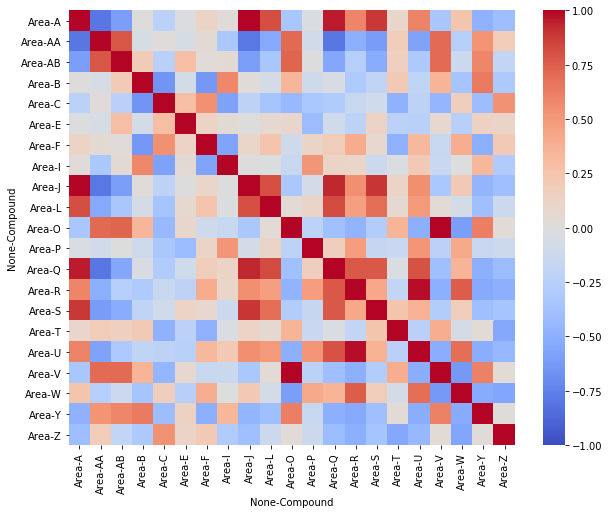

In [18]:
plt.figure(figsize=(10,8))
sns.heatmap(selected_wide.corr(), cmap='coolwarm', vmin=-1)
plt.savefig('fig/impurityCorrelationMatrix.pdf')

### PCA

The robustness was checked of the obtained PCA by leave-one-out validation. Only minor differences were observed in the explained variance when one sample is left out.

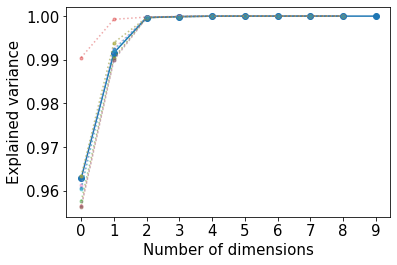

In [23]:
pca = PCA()
pca.fit(selected_wide)
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o')

markup = dict(fontsize=15)

for leaveout in selected_wide.index:
    pca.fit(selected_wide.drop(leaveout))
    plt.plot(
        np.cumsum(pca.explained_variance_ratio_), 
        alpha=.4, 
        ls=':',
        marker='.'
    )
    
plt.xlabel("Number of dimensions", **markup)
plt.ylabel("Explained variance", **markup)
plt.xticks(np.arange(0, 10, step=1), **markup)
plt.yticks(**markup)
plt.gcf().subplots_adjust(bottom=0.15, left = 0.15)
plt.savefig('fig/S3.pdf')

#### Score plot

The different synthesis routes are well separated on the first component of the PCA.

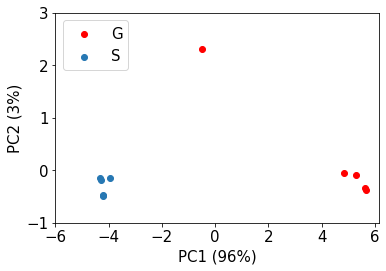

In [49]:
pca = PCA()
pca_data = pd.DataFrame(
    pca.fit_transform(selected_wide), 
    index=selected_wide.index
)

pca_data_g = pca_data.loc[pca_data.index.get_level_values('Synthesis') == 'G']
pca_data_s = pca_data.loc[pca_data.index.get_level_values('Synthesis') == 'S']

palette = dict(G="#ff0000", S="#2778b3")

plt.scatter(pca_data_g[0], pca_data_g[1], c=palette['G'], label='G')
plt.scatter(pca_data_s[0], pca_data_s[1], c=palette['S'], label='S')
plt.xlabel(f'PC1 ({round(pca.explained_variance_ratio_[0],2):.0%})', **markup)
plt.ylabel(f'PC2 ({round(pca.explained_variance_ratio_[1],2):.0%})', **markup)
plt.legend(fontsize=15, loc='upper left')
plt.xticks(np.arange(-6, 7, step=2), **markup)
plt.yticks(np.arange(-1, 4, step=1), **markup)
plt.gcf().subplots_adjust(bottom=0.15, left = 0.15)

plt.savefig('fig/5a.pdf') # Save image.

#### PCA loadings

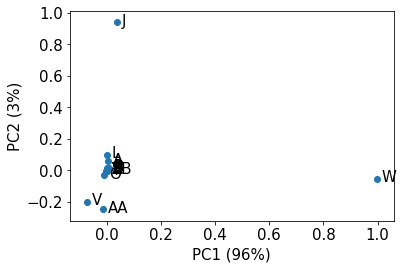

In [51]:
loadings = pd.DataFrame(
    pca.components_, 
    columns=selected_wide['Area'].columns
)
loadings = loadings.T[[0, 1]]

plt.scatter(loadings[0], loadings[1])
plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.0%})', **markup)
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.0%})', **markup)
for label, x, y in loadings.itertuples():
    if x>-0.3 or y>-0.3:
       plt.annotate(
           s=label, 
           xy=(x, y), 
           xytext=(5, -3), 
           textcoords=('offset pixels', 'offset pixels'), 
           **markup
       )

plt.xticks(**markup)
plt.yticks(**markup)
plt.gcf().subplots_adjust(left=0.15, bottom=0.15)

plt.savefig('fig/5b.pdf')

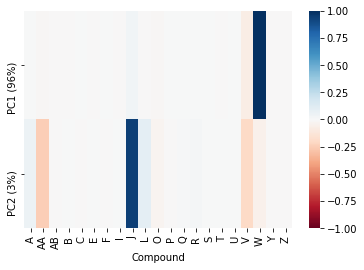

In [52]:
sns.heatmap(
    loadings.T, 
    vmin=-1, 
    vmax=1, 
    cmap='RdBu', 
    yticklabels=[
        f"PC1 ({pca.explained_variance_ratio_[0]:.0%})",
        f"PC2 ({pca.explained_variance_ratio_[1]:.0%})"
    ])
plt.savefig('fig/5b-heatmap.pdf')

### PCA in combination with LDA

In [88]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca_data = pca.fit_transform(selected_wide)

lda = LinearDiscriminantAnalysis().fit_transform(
    X=data, 
    y=selected_wide.index.get_level_values('Synthesis')
)
lda_df = pd.DataFrame(lda, index=selected_wide.index, columns=['lda'])

In [89]:
lda_df

lda
Synthesis N   Incubation Storage           
G         1.0 pre        RT      -15.310246
                         freezer -14.184782
          2.0 pre        freezer -14.279684
          3.0 pre        RT      -14.476553
                         freezer -14.673189
S         1.0 pre        freezer  12.884711
          2.0 pre        RT       15.944893
                         freezer  15.959175
          3.0 pre        RT       14.204812
                         freezer  13.930862

#### Kernel density estimations

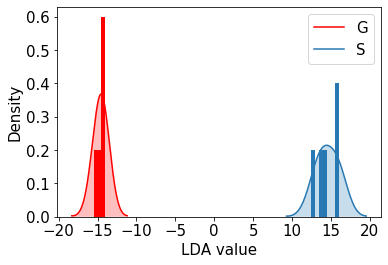

In [105]:
def plot_hist(data, n, color, binwidth=.5):
    """Plot a histogram such that the density is one."""
    plt.hist(
        data, 
        bins=np.arange(np.floor(data.min()), data.max()+binwidth, binwidth),
        weights=np.repeat(1/n, len(data)),
        color=color
    )

lda_df_g = lda_df[lda_df.index.get_level_values('Synthesis') == 'G']
lda_df_s = lda_df[lda_df.index.get_level_values('Synthesis') == 'S']

plot_hist(lda_df_g.values, n=len(lda_df_g), color='#ff0000')
plot_hist(lda_df_s.values, n=len(lda_df_s), color='#2778b3')
sns.kdeplot(lda_df_g['lda'], shade=True, bw=1,   label='G', color='#ff0000')
sns.kdeplot(lda_df_s['lda'], shade=True, bw=1.2, label='S', color='#2778b3')
plt.xlabel('LDA value', **markup)
plt.ylabel('Density', **markup)

plt.yticks(**markup)
plt.xticks(**markup)

plt.legend(**markup)
plt.gcf().subplots_adjust(left=0.15, bottom=0.15)
plt.savefig('fig/6.pdf')

#### Likelihood function

The likelihoods are determined from the ratio of the kernel density estimation at a given LDA value.

The following likelihood function calculates a given LDA-score (as calculated by LinearDiscriminantAnalysis.fit()) to the following function: $LR=\frac{p\left(E|H_1\right)}{p\left(E|H_2\right)}$

* $H_1$: The victim has been exposed to fentanyl produced with the Gupta method.
* $H_2$: The victim has been exposed to fentanyl produced with the Siegrief method.

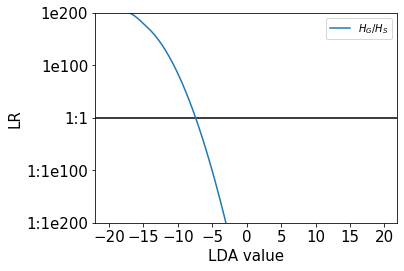

In [132]:
from scipy import stats
def likelihood(lda_score):
    """Calculate the Likelihood ratio for a given lda_score"""
    kernel_G = stats.gaussian_kde(lda_df_g['lda'])
    kernel_S = stats.gaussian_kde(lda_df_s['lda'])
    return kernel_G(lda_score)/kernel_S(lda_score)

x = np.arange(-20, 20, 0.1)
y = likelihood(x)

fig, ax = plt.subplots()
ax.axhline(1, color='black')
ax.plot(x, y, label=r'$H_G / H_S$')

ax.set_yscale('log')
ax.set_ylim(1e-200, 1e200)

ax.set_yticks([1e-200, 1e-100, 1e0, 1e100, 1e200])
ax.set_yticklabels(['1:1e200', '1:1e100', '1:1', '1e100', '1e200'])

plt.yticks(**markup)
plt.xticks(**markup)

ax.set_xlabel('LDA value', **markup)
ax.set_ylabel('LR', **markup)

plt.gcf().subplots_adjust(bottom=0.15, left = 0.2)
plt.legend()
plt.savefig('fig/lr.pdf')

#### Tippett plot

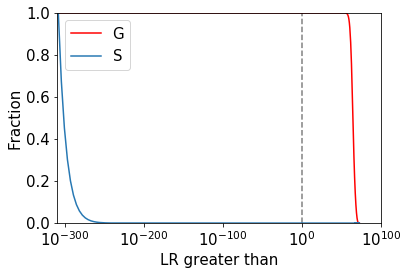

In [133]:
kde_g = stats.gaussian_kde(lda_df_g['lda'], bw_method=1)
kde_s = stats.gaussian_kde(lda_df_s['lda'], bw_method=1.2)

def cum_and_norm(x): return np.cumsum(x)/sum(x)
def likelihood(lda_score: float): return kde_g(lda_score)/kde_s(lda_score)

x_range = np.arange(-20, 3, .1) #LDA
x_ = [likelihood(x_) for x_ in x_range]
y_g_ = cum_and_norm([kde_g(x_) for x_ in x_range])
y_s_ = cum_and_norm([kde_s(x_) for x_ in x_range])

plt.axvline(x=1, color='grey',  ls='--')
plt.plot(x_, y_g_, label='G', color='#ff0000')
plt.plot(x_, y_s_, label='S', color='#2778b3')
plt.xlabel('LR greater than', **markup)
plt.ylabel('Fraction', **markup)
plt.xscale('log')
plt.xlim(1e-310, 1e100)
plt.xticks([1e-300, 1e-200, 1e-100, 1e0, 1e100])

plt.yticks(**markup)
plt.xticks(**markup)
plt.ylim(0, 1)

plt.legend(fontsize=15)
plt.gcf().subplots_adjust(left=0.15, bottom=0.15)
plt.savefig('fig/9.pdf')